In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as ip

In [2]:
np.random.seed(0)

def generate_xy():
    x = np.random.uniform(low = 0, high = 20, size = 10)
    x.sort()
    y = np.random.uniform(low = 0, high = 10, size = 10)
    return (x, y)

def show_interpolated(interpolator, x, y):
    x_new = np.arange(x[0], x[-1], 0.01)
    y_new = interpolator(x_new)

    plt.plot(x, y, 'o', x_new, y_new, '-')
    plt.show()
    

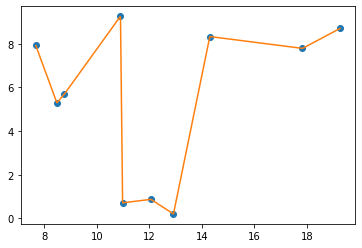

In [3]:
(x, y) = generate_xy()
f = ip.interp1d(x, y)
show_interpolated(f, x, y)

In [4]:
class Interpolator:
    xs = []
    ys = []

    def __init__(self, xs, ys):
        self.xs = xs
        self.ys = ys

    def __call__(self, arg_xs):
        assert(self.xs[0] <= arg_xs[0])
        assert(self.xs[-1] > arg_xs[-1])

        res = []

        curr_border = int(0)
        for x in arg_xs:
            while x > self.xs[curr_border]:
                curr_border += 1
            y = self.count_y_in_border(curr_border, x)
            res.append(y)
        return res

class InterpNext(Interpolator):
    def count_y_in_border(self, curr_border: int, x):
        return self.ys[curr_border]

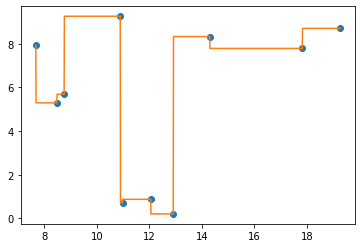

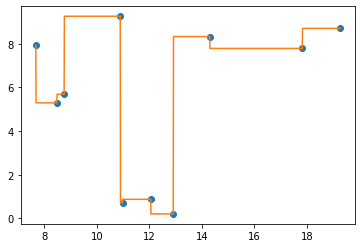

In [5]:
my_f = InterpNext(x, y)
sp_f = ip.interp1d(x, y, kind="next")

show_interpolated(my_f, x, y)
show_interpolated(sp_f, x, y)

### Квадратичная интерполяция
Разобьём данный набор из _n_ _x_-ов на _n - 1_ интервал

В каждом построим параболу (то, есть, найдём её коэффициенты, всего _3(n - 1)_ коэффициентов)

* 2 из трёх уравнений для каждой возьмём из граничных точек 
* 3-е - из знания о гладкости функции: наша производная в левой границе = производной соседа в правой границе
* таких уравнений не хватит на самую левую параболу, скажем, что там _a = 0_

In [6]:
def create_quad_func(a, b, c):
    return lambda x: a * x * x + b * x + c

class InterpQuad(Interpolator):
    def __init__(self, xs, ys):
        super().__init__(xs, ys)
        n = len(xs)

        matrix = self.prepare_mtx_of_size(n - 1)
        ys_vec = np.zeros((n - 1) * 3)
        for i in range(0, n - 1):
            ys_vec[i * 2] = ys[i]
            ys_vec[i * 2 + 1] = ys[i + 1]
        coeffs = np.linalg.solve(matrix, ys_vec)
        self.funcs = [None] * (n - 1)
        for i in range(0, n - 1):
            idx = i * 3
            a = coeffs[idx]
            b = coeffs[idx + 1]
            c = coeffs[idx + 2]
            self.funcs[i] = create_quad_func(a, b, c)


    def prepare_mtx_of_size(self, n: int):
        matrix = np.zeros((n * 3, n * 3))
        for i in range(0, n):
            row = i * 2
            col = i * 3
            x1 = self.xs[i]
            x2 = self.xs[i + 1]

            matrix[row:row+2, col] = [x1 * x1, x2 * x2]
            matrix[row:row+2, col+1] = [x1, x2]
            matrix[row:row+2, col+2] = 1

            if i < n - 1:
                row = n * 2 + i
                matrix[row, col] = 2 * x2
                matrix[row, col + 1] = 1
                matrix[row, col + 3] = -2 * x2
                matrix[row, col + 4] = -1
        matrix[-1, 0] = 1
        return matrix

    def count_y_in_border(self, border_idx: int, x):
        border_idx = np.clip(border_idx - 1, 0, len(self.xs) - 1)
        return self.funcs[border_idx](x)


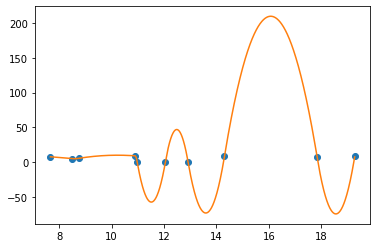

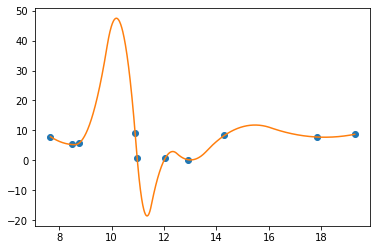

In [7]:
my_interp = InterpQuad(x, y)
sp_interp = ip.interp1d(x, y, kind="quadratic")

show_interpolated(my_interp, x, y)
show_interpolated(sp_interp, x, y)

Разница объясняется способами поиска коэффициентов парабол

scipy, в отличие от описанного выше алгоритма, строит их по тройкам точек (это можно заподозрить по графику, а ещё он падает, если скормить меньше трёх точек)